# Ejercicio 2

In [36]:
# --------- Leer el texto desde el archivo ---------
with open("Pradera\datos\informacion\Mecanica_del_juego.txt", "r", encoding="utf-8") as file:
    texto = file.read()


In [37]:
import re
# Limpieza del texto (antes de fragmentar)
def limpiar_texto(texto):
    texto = texto.strip()
    texto = re.sub(r'\s+', ' ', texto)
    return texto

texto_limpio = limpiar_texto(texto)

In [38]:
from langchain.text_splitter import CharacterTextSplitter

# Esto intenta no cortar palabras ni oraciones, buscando separadores (como "\n" o ". ") antes del l√≠mite.

# Crear el splitter
splitter = CharacterTextSplitter(
    separator="\n",            
    chunk_size=200, # Divide cada 200 caracteres
    chunk_overlap=0,           
    length_function=len
)

# Generar los fragmentos
fragmentos = splitter.split_text(texto)

# Ver cantidad de fragmentos
print(f"Total de fragmentos generados: {len(fragmentos)}")

# Ver algunos ejemplos
for i, frag in enumerate(fragmentos[:3]):
    print(f"\n--- Fragmento {i+1} ---\n{frag}")

Created a chunk of size 301, which is longer than the specified 200
Created a chunk of size 275, which is longer than the specified 200
Created a chunk of size 426, which is longer than the specified 200
Created a chunk of size 288, which is longer than the specified 200
Created a chunk of size 1086, which is longer than the specified 200
Created a chunk of size 668, which is longer than the specified 200
Created a chunk of size 466, which is longer than the specified 200
Created a chunk of size 467, which is longer than the specified 200
Created a chunk of size 395, which is longer than the specified 200
Created a chunk of size 224, which is longer than the specified 200
Created a chunk of size 254, which is longer than the specified 200
Created a chunk of size 208, which is longer than the specified 200
Created a chunk of size 425, which is longer than the specified 200
Created a chunk of size 512, which is longer than the specified 200
Created a chunk of size 500, which is longer th

Total de fragmentos generados: 49

--- Fragmento 1 ---
Convi√©rtete en un explorador que compite con otros por ver qui√©n es el observador de la naturaleza m√°s h√°bil en un viaje para el que no se necesita m√°s que el deseo por descubrir los misterios de la naturaleza y una mirada llena de curiosidad por cada peque√±o detalle que nos encontremos en el camino.

--- Fragmento 2 ---
As√≠ se nos presenta Pradera, dise√±ado por Klemens Kalicki, responsable de Dream Home. El juego fue publicado en 2021 por Rebel Studio en una versi√≥n en polaco. De las ilustraciones se encarga Karolina Kijak, siendo esta su primera incursi√≥n en el mundo de los juegos de mesa.

--- Fragmento 3 ---
Se encuentra publicado en espa√±ol por Asmodee Ib√©rica (aunque el juego es completamente independiente del idioma). Permite partidas de 1 a 4 jugadores, con una edad m√≠nima sugerida de 10 a√±os y una duraci√≥n aproximada de entre 60 y 90 minutos. El precio de venta al p√∫blico es de 44,99‚Ç¨. Para esta rese√±a s

In [39]:
# Vectorizaci√≥n de los fragmentos
from sentence_transformers import SentenceTransformer
from prettytable import PrettyTable

# Cargamos el modelo preentrenado multiling√ºe
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Codificamos los fragmentos
embeddings = modelo.encode(fragmentos, convert_to_tensor=True)

In [40]:
from sentence_transformers import util
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
import Levenshtein as lev
import numpy as np


frases_busqueda = [
    "¬øCu√°les son las reglas b√°sicas del juego de mesa?",
    "C√≥mo se juega a este juego de mesa",
    "Objetivo principal del juego",
    "Tipos de cartas en el juego",
    "Estrategias ganadoras en juegos de mesa",
    "N√∫mero de jugadores recomendado para este juego",
    "¬øEs este juego cooperativo o competitivo?",
    "Historia del juego de mesa",
    "¬øQu√© hace especial este juego?",
    "¬øC√≥mo se distribuyen las cartas en este juego?"
]

# Codificar los fragmentos y las frases de b√∫squeda
embeddings = modelo.encode(fragmentos, convert_to_tensor=True)
embeddings_busqueda = modelo.encode(frases_busqueda, convert_to_tensor=True)

# Funci√≥n para calcular la similitud del coseno
def similitud_coseno(embedding1, embedding2):
    return util.cos_sim(embedding1, embedding2).item()

# Funci√≥n para calcular la distancia de Jaccard
def distancia_jaccard(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - intersection / union  # Jaccard devuelve la distancia, no la similitud

# Funci√≥n para calcular la distancia de Levenshtein
def distancia_levenshtein(str1, str2):
    return lev.distance(str1, str2)

# Funci√≥n para calcular el √≠ndice de Dice
def indice_dice(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    return 2 * intersection / (len(set1) + len(set2))  # Dice devuelve la similitud

# Funci√≥n para calcular la similitud de Jaro-Winkler
def similitud_jaro_winkler(str1, str2):
    return fuzz.ratio(str1, str2) / 100  # Jaro-Winkler es un porcentaje

# Crear una tabla para mostrar los resultados
tabla = PrettyTable()
tabla.field_names = ["Frase de B√∫squeda", "Fragmento", "Similitud Coseno", "Distancia Jaccard", "Distancia Levenshtein", "√çndice Dice", "Similitud Jaro-Winkler"]

# Comparar todas las frases de b√∫squeda con todos los fragmentos
for i, frase in enumerate(frases_busqueda):
    for j, fragmento in enumerate(fragmentos):
        similitud_cos = similitud_coseno(embeddings_busqueda[i], embeddings[j])
        jaccard = distancia_jaccard(frase, fragmento)
        levenshtein = distancia_levenshtein(frase, fragmento)
        dice = indice_dice(frase, fragmento)
        jaro_winkler = similitud_jaro_winkler(frase, fragmento)

        # A√±adir la fila a la tabla
        tabla.add_row([frase, fragmento, f"{similitud_cos:.4f}", f"{jaccard:.4f}", f"{levenshtein:.4f}", f"{dice:.4f}", f"{jaro_winkler:.4f}"])

# Mostrar la tabla con los resultados
print(tabla)


+---------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

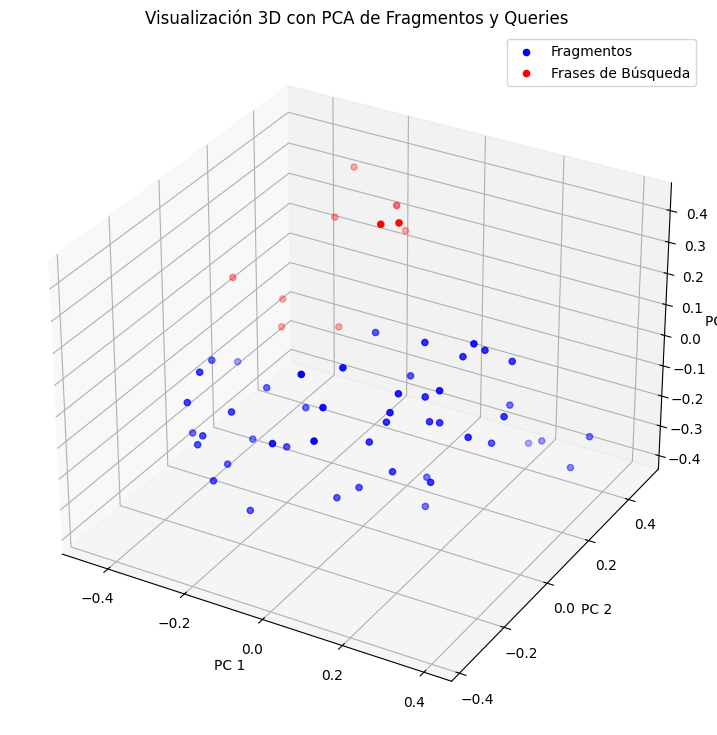

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Combina los embeddings de fragmentos y frases de b√∫squeda
todos_embeddings = embeddings.cpu().numpy().tolist() + embeddings_busqueda.cpu().numpy().tolist()


# Aplica PCA para reducir a 3 dimensiones
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(todos_embeddings)

# Separa fragmentos y frases de b√∫squeda
num_fragmentos = len(fragmentos)
emb_frag = embeddings_3d[:num_fragmentos]
emb_query = embeddings_3d[num_fragmentos:]

# Visualizaci√≥n 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Fragmentos en azul
ax.scatter(emb_frag[:, 0], emb_frag[:, 1], emb_frag[:, 2], c='blue', label='Fragmentos')
# Frases de b√∫squeda en rojo
ax.scatter(emb_query[:, 0], emb_query[:, 1], emb_query[:, 2], c='red', label='Frases de B√∫squeda')



ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Visualizaci√≥n 3D con PCA de Fragmentos y Queries')
ax.legend()
plt.show()


# Ejercicio 3

In [42]:
import spacy

# Carga el modelo en espa√±ol con soporte para POS y NER
nlp = spacy.load('es_core_news_lg')

# Creamos una lista para almacenar los sustantivos por fragmento para su posterior an√°lisis
sustantivos_por_fragmento = []

for i, fragmento in enumerate(fragmentos):
    doc = nlp(fragmento)
    
    print(f"\n--- Fragmento {i+1} ---")
    print(f"Texto: {fragmento}\n")

    # 1. Extraer frases nominales (noun_chunks = frases con n√∫cleo sustantivo)
    print("Frases nominales (POS):")
    for chunk in doc.noun_chunks:
        print(f" - {chunk.text}")

    # 2. Extraer entidades nombradas (NER)
    print("\nEntidades nombradas (NER):")
    for ent in doc.ents:
        print(f" - {ent.text} ({ent.label_})")

    # 3. Sustantivos (guardarlos para an√°lisis posterior)
    sustantivos = [token.lemma_.lower() for token in doc if token.pos_ == "NOUN"]
    print("\nSustantivos extra√≠dos (lemmatizados):")
    print(sustantivos)
    
    # Guardar en la lista principal
    sustantivos_por_fragmento.append(sustantivos)


--- Fragmento 1 ---
Texto: Convi√©rtete en un explorador que compite con otros por ver qui√©n es el observador de la naturaleza m√°s h√°bil en un viaje para el que no se necesita m√°s que el deseo por descubrir los misterios de la naturaleza y una mirada llena de curiosidad por cada peque√±o detalle que nos encontremos en el camino.

Frases nominales (POS):
 - Convi√©rtete
 - un explorador
 - que
 - otros
 - qui√©n
 - la naturaleza
 - un viaje
 - el que
 - m√°s que el deseo
 - los misterios
 - la naturaleza
 - una mirada
 - curiosidad
 - cada peque√±o detalle
 - que
 - el camino

Entidades nombradas (NER):

Sustantivos extra√≠dos (lemmatizados):
['explorador', 'observador', 'naturaleza', 'viaje', 'deseo', 'misterio', 'naturaleza', 'mirada', 'curiosidad', 'detalle', 'camino']

--- Fragmento 2 ---
Texto: As√≠ se nos presenta Pradera, dise√±ado por Klemens Kalicki, responsable de Dream Home. El juego fue publicado en 2021 por Rebel Studio en una versi√≥n en polaco. De las ilustraciones s

In [43]:
# CODIGO PARA VISUALIZAR UN FRAGMENTO EN PARTICULAR

indice_fragmento = 2  

fragmento = fragmentos[indice_fragmento]
doc = nlp(fragmento)

print(f"\n--- Fragmento {indice_fragmento + 1} ---")
print(f"Texto: {fragmento}\n")

# 1. Frases nominales (POS)
print("Frases nominales (POS):")
for chunk in doc.noun_chunks:
    print(f" - {chunk.text}")

# 2. Entidades nombradas con explicaci√≥n (NER)
print("\nEntidades nombradas (NER):")
if doc.ents:
    for ent in doc.ents:
        print(f" - Entidad: {ent.text}, Etiqueta: {ent.label_}, Explicaci√≥n: {spacy.explain(ent.label_)}")
else:
    print("No se encontraron entidades nombradas en este fragmento.")


--- Fragmento 3 ---
Texto: Se encuentra publicado en espa√±ol por Asmodee Ib√©rica (aunque el juego es completamente independiente del idioma). Permite partidas de 1 a 4 jugadores, con una edad m√≠nima sugerida de 10 a√±os y una duraci√≥n aproximada de entre 60 y 90 minutos. El precio de venta al p√∫blico es de 44,99‚Ç¨. Para esta rese√±a se ha utilizado una copia de la versi√≥n en espa√±ol de Asmodee Ib√©rica, que la propia editorial nos ha cedido amablemente.

Frases nominales (POS):
 - espa√±ol
 - Asmodee Ib√©rica
 - el juego
 - idioma
 - partidas
 - 4 jugadores
 - , con una edad m√≠nima
 - 10 a√±os
 - una duraci√≥n
 - entre 60 y 90 minutos
 - El precio
 - venta
 - p√∫blico
 - esta rese√±a
 - una copia
 - la versi√≥n
 - espa√±ol
 - Asmodee Ib√©rica
 - la propia editorial

Entidades nombradas (NER):
 - Entidad: Asmodee Ib√©rica, Etiqueta: MISC, Explicaci√≥n: Miscellaneous entities, e.g. events, nationalities, products or works of art
 - Entidad: El precio de venta al p√∫blico, Etiqu

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

# üîπ Similitud de Jaccard
def similitud_jaccard(lista1, lista2):
    set1 = set(lista1)
    set2 = set(lista2)
    interseccion = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(interseccion) / len(union)

# üîπ Similitud de Levenshtein
def similitud_levenshtein(lista1, lista2):
    if not lista1 or not lista2:
        return 0.0
    puntajes = []
    for palabra1 in lista1:
        mejores_similitudes = []
        for palabra2 in lista2:
            dist = distancia_levenshtein(palabra1, palabra2)
            max_len = max(len(palabra1), len(palabra2))
            if max_len == 0:
                similitud = 1.0  # ambas palabras vac√≠as
            else:
                similitud = 1 - dist / max_len
            mejores_similitudes.append(similitud)
        puntajes.append(max(mejores_similitudes))
    return np.mean(puntajes)


# üîπ √çndice de Dice
def similitud_dice(lista1, lista2):
    set1 = set(lista1)
    set2 = set(lista2)
    interseccion = len(set1.intersection(set2))
    total = len(set1) + len(set2)
    if total == 0:
        return 0.0
    return 2 * interseccion / total

# üîπ Similitud del Coseno (basado en bolsa de palabras)
def similitud_coseno_bow(lista1, lista2):
    documentos = [' '.join(lista1), ' '.join(lista2)]
    vectorizer = CountVectorizer().fit_transform(documentos)
    vectores = vectorizer.toarray()
    return cosine_similarity([vectores[0]], [vectores[1]])[0][0]

# üîπ Similitud de Jaro-Winkler (promedio entre palabras)
def similitud_jaro_winkler(lista1, lista2):
    if not lista1 or not lista2:
        return 0.0
    puntajes = []
    for palabra1 in lista1:
        mejores_similitudes = [fuzz.WRatio(palabra1, palabra2) for palabra2 in lista2]
        puntajes.append(max(mejores_similitudes))
    return np.mean(puntajes) / 100  # para dejarlo en [0,1]

In [45]:
# Ejemplo: comparar fragmento 0 y 1
lista1 = sustantivos_por_fragmento[0]
lista2 = sustantivos_por_fragmento[1]

print("Similitud Jaccard:", similitud_jaccard(lista1, lista2))
print("Similitud Dice:", similitud_dice(lista1, lista2))
print("Similitud Coseno (BoW):", similitud_coseno_bow(lista1, lista2))
print("Similitud Levenshtein:", similitud_levenshtein(lista1, lista2))
print("Similitud Jaro-Winkler:", similitud_jaro_winkler(lista1, lista2))

Similitud Jaccard: 0.0
Similitud Dice: 0.0
Similitud Coseno (BoW): 0.0
Similitud Levenshtein: 0.2895316804407713
Similitud Jaro-Winkler: 0.48727272727272725


# Ejercicio 4

In [46]:
from langdetect import detect
import os
import pandas as pd

carpeta = "Pradera/datos/informacion"

# Lista para guardar los resultados
datos = []

# Recorrer todos los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta):
    ruta_archivo = os.path.join(carpeta, nombre_archivo)

    # Solo procesar archivos .txt
    if nombre_archivo.endswith(".txt"):
        with open(ruta_archivo, "r", encoding="utf-8") as archivo:
            texto = archivo.read()

            # Detectar idioma
            try:
                idioma = detect(texto)
            except:
                idioma = "desconocido"

            # Guardar en la lista
            datos.append({
                "archivo": nombre_archivo,
                "idioma": idioma,
                "texto": texto
            })

# Crear el DataFrame
df_idiomas = pd.DataFrame(datos)

# Mostrar el DataFrame
df_idiomas.head()


archivo idioma  \
0          comentarios.txt     es   
1  descripcion_general.txt     en   
2     enlaces_imagenes.txt     fr   
3       enlaces_pagina.txt     es   
4         foro_general.txt     en   

                                               texto  
0  1 Espectacular. Desde que se anunci√≥ ya me lla...  
1  Meadow is an engaging set collection game with...  
2  https://i0.wp.com/misutmeeple.com/wp-content/u...  
3  #Colecciones\nhttps://misutmeeple.com/tag/cole...  
4  Missed card packs ?: Hello everyone\n\nAfter c...

# Ejercicio 5

In [47]:
# Ruta al archivo
ruta_archivo = "Pradera/datos/informacion/comentarios.txt"

# Leer rese√±as correctamente
resenias = []
rese√±a_actual = ""

with open(ruta_archivo, "r", encoding="utf-8") as file:
    for linea in file:
        linea = linea.strip()
        if not linea:
            continue
        # Si la l√≠nea empieza con un n√∫mero y un espacio, es una nueva rese√±a
        if re.match(r"^\d+\s", linea):
            if rese√±a_actual:
                resenias.append(rese√±a_actual.strip())  # Guardar la anterior
            # Eliminar el n√∫mero y guardar el nuevo comienzo
            rese√±a_actual = re.sub(r"^\d+\s+", "", linea)
        else:
            rese√±a_actual += " " + linea  # Continuaci√≥n de la rese√±a actual

# Guardar la √∫ltima rese√±a si qued√≥ alguna
if rese√±a_actual:
    resenias.append(rese√±a_actual.strip())

# Crear DataFrame
df_resenias = pd.DataFrame(resenias, columns=["texto"])

# Verificar una rese√±a puntual
print(resenias[49])


Un juegazo. Y con la ultima expansi√≥n aun mas. xD


In [48]:
df_resenias.head()

texto
0  Espectacular. Desde que se anunci√≥ ya me llam√≥...
1  A mi me tiene encandilado. No deja de ser un j...
2  Gran rese√±a, como siempre. Est√° gustando mucho...
3  A mi siempre me deja con ganas de seguir jugan...
4  Hola Iv√°n, la verdad es que me has sorprendido...

In [49]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cpu


In [50]:
# Agrego etiquetas para que sea mas representativo
etiquetas_map = {
    "1 star": "Muy negativo",
    "2 stars": "Negativo",
    "3 stars": "Neutral",
    "4 stars": "Positivo",
    "5 stars": "Muy positivo"
}

# Analizar el sentimiento de cada rese√±a utilizando el modelo preentrenado
sentimientos = []
for texto in df_resenias["texto"]:
    resultado = nlp(texto[:512])[0]  # Truncar texto largo
    etiqueta = resultado["label"]
    sentimiento = etiquetas_map.get(etiqueta, "Desconocido")
    sentimientos.append(sentimiento)

df_resenias["Sentimiento"] = sentimientos


In [51]:
df_resenias.head(5)


texto   Sentimiento
0  Espectacular. Desde que se anunci√≥ ya me llam√≥...  Muy positivo
1  A mi me tiene encandilado. No deja de ser un j...  Muy positivo
2  Gran rese√±a, como siempre. Est√° gustando mucho...      Positivo
3  A mi siempre me deja con ganas de seguir jugan...      Positivo
4  Hola Iv√°n, la verdad es que me has sorprendido...       Neutral

In [52]:
# Cargar modelo para b√∫squeda sem√°ntica asim√©trica
modelo = SentenceTransformer('msmarco-MiniLM-L-6-v3')

# Consultas simuladas
consultas = [
    "¬øQu√© tan educativo es el juego?",
    "¬øEl juego es divertido para jugar con ni√±os?",
    "¬øVale la pena por los componentes?",
    "¬øEs entretenido a largo plazo?",
    "¬øEl juego es complejo o f√°cil de aprender?",
    "¬øEs bueno para jugar en familia?",
    "¬øSe siente repetitivo despu√©s de algunas partidas?"
]

# Embeddings de consultas
incrustaciones_consultas = modelo.encode(consultas, convert_to_tensor=True)

# Embeddings de rese√±as (respuestas)
respuestas = df_resenias["texto"].tolist()
incrustaciones_respuestas = modelo.encode(respuestas, convert_to_tensor=True)

# Elegir tipo de sentimiento deseado
sentimiento_deseado = "Muy positivo"


# Buscar la mejor respuesta para cada consulta
for i, consulta in enumerate(consultas):
    similitudes = util.cos_sim(incrustaciones_consultas[i], incrustaciones_respuestas)[0]
    mejores_indices = similitudes.topk(k=10).indices.tolist()

    print(f"üîç Consulta: {consulta}")
    count = 0
    for idx in mejores_indices:
        if df_resenias.iloc[idx]['Sentimiento'] == sentimiento_deseado:
            print(f"\nüîπ Rese√±a relacionada (Similitud: {similitudes[idx]:.4f}):")
            print(f"{respuestas[idx]}")
            print(f"üìä Sentimiento: {df_resenias.iloc[idx]['Sentimiento']}")
            count += 1
            if count >= 3:
                break
    print("=" * 100)

üîç Consulta: ¬øQu√© tan educativo es el juego?

üîπ Rese√±a relacionada (Similitud: 0.4644):
Much√≠simas gracias!! Me alegra de que el contenido os sirva. Y Pradera es de esos juegos que entran solos en cualquier ludoteca porque lo tiene todo como juego cuasi familiar.
üìä Sentimiento: Muy positivo

üîπ Rese√±a relacionada (Similitud: 0.4637):
Muchas gracias por la rese√±a, Iv√°n. En mi caso lo compr√© cuando sali√≥ porque hab√≠a visto como se jugaba y me hab√≠a llamado mucho la atenci√≥n. En casa ha ca√≠do de pie y nos encanta, ha sido un gran acierto. Pero el mejor acierto es seguir tu blog, por tema econ√≥mico y de espacio tengo que ser muy selectivo a la hora de comprar y al ver la nota que le has puesto a este  juego pienso que he acertado, al final me estas contagiando el buen gusto. Solamente llevamos un par de a√±os metidos de lleno en el mundillo y muchos de los juegos de nuestra colecci√≥n te los debemos a ti, la facilidad de ver a trav√©s de tus rese√±as si el juego nos

# Ejercicio 6

### Consultas

In [32]:
consultas_categorizadas = [
    {"consulta": "¬øQu√© es el juego Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es el objetivo principal de Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son los componentes del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°ntos jugadores pueden jugar Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la duraci√≥n aproximada de una partida?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se prepara el juego antes de empezar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las reglas b√°sicas para ganar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo funciona el sistema de puntuaci√≥n?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© habilidades se desarrollan jugando Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øD√≥nde puedo encontrar el reglamento oficial?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øExisten variantes oficiales del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øHay tutoriales en video disponibles?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© estrategias se recomiendan para principiantes?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© idioma tiene el reglamento original?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe puede jugar en l√≠nea o s√≥lo en f√≠sico?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQui√©n dise√±√≥ el juego Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la historia detr√°s del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øD√≥nde puedo comprar Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øHay alguna expansi√≥n para el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipo de tablero utiliza Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipo de dados se usan en Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se usa el tablero durante el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°ntas cartas hay en el mazo?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la edad recomendada para jugar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se inicia una partida?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe puede jugar Pradera en equipos?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© pasa si un jugador se queda sin cartas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se realiza un movimiento v√°lido?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las penalizaciones en el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se gana el desempate?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øHay reglas especiales para la variante en l√≠nea?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipo de estrategias avanzadas existen?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© recursos vienen incluidos en la caja?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øEs necesario un √°rbitro para jugar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°nto tiempo dura la preparaci√≥n antes del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe puede modificar el reglamento?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se configuran las piezas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© pasa si un jugador abandona la partida?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se realiza el conteo de puntos final?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øExisten torneos oficiales de Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la historia del dise√±o del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQui√©nes son los autores del reglamento?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øHay alguna app oficial de Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe pueden personalizar las piezas del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se manejan los empates en partidas m√∫ltiples?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© idiomas est√°n disponibles para el reglamento?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las normas para jugar con ni√±os?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© materiales se usan para las piezas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øD√≥nde puedo descargar el reglamento en PDF?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la mejor manera de guardar el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se resuelven disputas durante el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe recomienda usar el juego para clases educativas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© variantes caseras existen para el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe pueden jugar partidas r√°pidas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo afecta el n√∫mero de jugadores la duraci√≥n?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipo de tableros alternativos se pueden usar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe puede jugar con menos piezas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© reglas se aplican en el modo solitario?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las recomendaciones para jugadores nuevos?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se realiza el setup inicial en la variante avanzada?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipos de cartas existen en el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe puede descargar material adicional para el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son los elementos de arte del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øExisten expansiones oficiales?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la mejor estrategia para jugar en familia?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© edad m√≠nima recomienda el fabricante?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la funci√≥n de cada tipo de pieza?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se hace el mantenimiento de las piezas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© sucede si se pierde alguna pieza?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las reglas para partidas en l√≠nea?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe puede jugar Pradera en dispositivos m√≥viles?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tan recomendado es el juego para principiantes?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© habilidades sociales promueve el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es el nivel de complejidad del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°ntas partidas se pueden jugar con una caja?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© soporte t√©cnico ofrece el fabricante?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe pueden imprimir reglas adicionales?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øExisten tutoriales en otros idiomas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipos de variantes est√°n permitidas en torneos?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se punt√∫an las acciones especiales?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la pol√≠tica de devoluci√≥n del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe recomienda jugar con reloj de tiempo?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se usa la carta comod√≠n?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°ndo fue lanzado el juego al mercado?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© hace especial a Pradera frente a otros juegos?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la tem√°tica principal del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipo de mec√°nicas utiliza Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© elementos del juego fomentan la colaboraci√≥n?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øD√≥nde est√°n ubicadas las reglas para el modo torneo?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øExisten ediciones especiales del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© son las cartas de evento?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se puede aprender a jugar r√°pido?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© papel juegan los recursos en el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe pueden jugar partidas con menos jugadores?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© pasa si se rompen las cartas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las fases del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se asignan los turnos?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© reglas aplican para el modo cooperativo?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipo de tablero se recomienda para torneos?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe puede jugar Pradera con adaptaciones para discapacitados?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo es el flujo de una partida t√≠pica?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© habilidades cognitivas desarrolla el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øExisten limitaciones de espacio para jugar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tama√±o tiene el tablero?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°ntos jugadores se necesitan para una partida oficial?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© materiales se usan para el tablero?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°nto pesa la caja del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øHay recomendaciones para almacenar el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la pol√≠tica de garant√≠a?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe recomienda usar protectores para las cartas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tama√±o tienen las cartas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la calidad del material de las piezas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las reglas para jugar en parejas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© elementos se pueden personalizar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipos de estrategias son efectivas en Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© accesorios adicionales se pueden comprar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo es el embalaje del juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la mejor forma de ense√±ar el juego a ni√±os?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© idiomas est√°n soportados en el tutorial?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la estructura del reglamento?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe recomienda jugar Pradera en grupos grandes?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las reglas para modificar el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo interpretar las ilustraciones del reglamento?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© hacer si hay una discrepancia en las reglas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las recomendaciones para partidas en exteriores?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se usa el reloj de arena en el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© pasa si se pierde la conexi√≥n durante una partida en l√≠nea?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipos de cartas especiales existen?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© variantes oficiales se recomiendan para expertos?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°nto tiempo dura una partida promedio?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© habilidades desarrolla Pradera en los ni√±os?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es la mejor edad para iniciar a jugar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© diferencias hay entre la versi√≥n f√≠sica y digital?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe pueden usar dados personalizados?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se limpia el tablero sin da√±arlo?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© opciones de soporte hay para dudas sobre el juego?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las normas para jugar en ferias o exposiciones?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipos de estrategias defensivas existen?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se usan los elementos del tutorial en la partida?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es el papel del azar en Pradera?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipos de tableros alternativos existen?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo se juega Pradera con solo dos jugadores?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°les son las reglas para partidas r√°pidas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© beneficios tiene jugar Pradera para la concentraci√≥n?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo preparar el juego para un torneo escolar?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© accesorios son recomendados para proteger las piezas?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øC√≥mo interpretar las cartas de evento?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© recursos online est√°n disponibles para aprender?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øSe puede jugar Pradera sin tablero?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øQu√© tipos de modos de juego existen?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°ndo se recomienda usar el modo experto?", "categoria": "Informaci√≥n"},
    {"consulta": "¬øCu√°l es el puntaje promedio del juego Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas personas han calificado Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es la desviaci√≥n est√°ndar del rating?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© peso tiene Pradera en t√©rminos de dificultad?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos comentarios hay sobre el juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos fans tiene Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas visitas de p√°gina ha recibido Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es el ranking general del juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øEn qu√© puesto est√° Pradera en la categor√≠a de estrategia?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© ranking tiene Pradera en la categor√≠a familiar?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas veces se ha jugado Pradera en total?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas partidas se jugaron este mes?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas personas poseen el juego actualmente?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas personas lo pose√≠an antes?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos lo tienen en su lista de intercambio?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas personas desean intercambiarlo?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas personas lo tienen en su lista de deseos?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos jugadores tienen partes del juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos usuarios desean partes del juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es el n√∫mero total de votos recibidos?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es la media del puntaje dado por los jugadores?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l fue la puntuaci√≥n m√°s com√∫n?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© tan popular es Pradera seg√∫n sus estad√≠sticas?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øC√≥mo ha sido la actividad del juego este mes?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos usuarios √∫nicos han jugado Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas veces lo han jugado todos los usuarios en total?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos lo han jugado al menos una vez?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es la tendencia de juego mensual?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos lo han eliminado de su colecci√≥n?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© lugar ocupa Pradera en los juegos m√°s jugados?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es el promedio de calificaciones que recibe Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© tan bien valorado est√° Pradera por los jugadores?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos usuarios han dejado su puntuaci√≥n en el juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es la variabilidad en las calificaciones del juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© nivel de complejidad le asignan los jugadores a Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos jugadores han comentado sobre el juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© cantidad de personas siguen o son fans de Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas visitas ha recibido la p√°gina del juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© posici√≥n ocupa Pradera en el ranking global de juegos?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øC√≥mo se posiciona Pradera en la categor√≠a de estrategia?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© puesto tiene Pradera dentro de los juegos familiares?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCon qu√© frecuencia se juega Pradera a lo largo del tiempo?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© volumen de partidas se ha registrado este mes?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas copias del juego est√°n en manos de los jugadores?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© porcentaje de jugadores sol√≠a tener el juego pero ya no?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos ejemplares est√°n disponibles para intercambio?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© tan demandado est√° Pradera en el mercado de intercambio?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos usuarios agregaron Pradera a su wishlist?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos usuarios poseen piezas o partes sueltas del juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos est√°n interesados en conseguir piezas faltantes?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas personas est√°n activamente siguiendo a Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es el total acumulado de jugadas de Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© volumen de actividad se ha visto recientemente en el juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© tan frecuentemente se califica el juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es la calificaci√≥n promedio ponderada de Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos jugadores tienen a Pradera en su lista de favoritos?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© tan estable es la popularidad del juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l fue el pico de popularidad de Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos jugadores agregaron rese√±as sobre el juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øEn cu√°ntas listas de intercambio aparece Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øC√≥mo var√≠a la cantidad de partidas jugadas mes a mes?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntas personas nuevas han jugado Pradera este mes?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© tan deseado es el juego por los nuevos jugadores?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øEn cu√°ntas colecciones aparece el juego actualmente?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es el crecimiento mensual de nuevos jugadores?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos votos positivos ha recibido el juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øC√≥mo ha variado la valoraci√≥n promedio a lo largo del tiempo?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQu√© lugar ocupa Pradera entre los juegos mejor calificados?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos jugadores han participado en encuestas sobre el juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°l es el engagement mensual promedio del juego?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øCu√°ntos votos totales se han registrado para Pradera?", "categoria": "Estad√≠stica"},
    {"consulta": "¬øQui√©n dise√±√≥ el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©n ilustr√≥ el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©n trabaj√≥ en el dise√±o gr√°fico de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©n fue el editor del juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© editoriales publicaron Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øCu√°ndo fue lanzado el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©n desarroll√≥ el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øCon qu√© otros nombres se conoce el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øC√≥mo se llama Meadow en japon√©s?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© nombres alternativos tiene Meadow en diferentes idiomas?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n existe entre Bryan Gerding y Nordy?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©nes colaboraron juntos en el desarrollo de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© ilustradores han trabajado juntos en Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øA qu√© categor√≠as pertenece el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© mec√°nicas usa el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© tipo de juego es Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øA qu√© familia de juegos pertenece Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© temas aborda el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øEst√° Meadow relacionado con juegos de ecolog√≠a?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n hay entre Klemens Kalicki y Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© otros juegos ha dise√±ado Klemens Kalicki?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n hay entre Karolina Kijak y Katarzyna Fiebiger?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©nes han colaborado con Karolina Kijak?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© editoriales distribuyeron el juego Meadow en distintos pa√≠ses?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© nombres alternativos tiene Meadow en Europa del Este?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© personas estuvieron involucradas en la creaci√≥n de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos comparten mec√°nicas con Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© otros juegos tienen la misma categor√≠a que Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos usan la mec√°nica de 'Hand Management' como Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos tienen la tem√°tica de naturaleza como Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n tiene Meadow con el tema de ecolog√≠a?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© versi√≥n digital existe del juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n tiene Meadow con Tabletopia?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©n escribi√≥ el contenido narrativo del juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos comparten la familia 'Theme: Nature' con Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos est√°n en la familia 'Mechanism: Tableau Building' como Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©n es Agnieszka Mo≈ºejko y qu√© hizo en Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© papel tuvo Nordy en el desarrollo de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© colaboraciones internas se dan en el equipo de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n existe entre los ilustradores del juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© otras funciones tuvo Katarzyna Fiebiger adem√°s de ilustradora?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© otros juegos fueron desarrollados por Klemens Kalicki?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© editoriales participaron en la publicaci√≥n internacional de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n hay entre Meadow y Rebel Studio?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© editoriales publicaron Meadow en Asia?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQui√©nes editaron el juego Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© autores tienen m√∫ltiples roles dentro del desarrollo de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© dise√±adores gr√°ficos participaron en la creaci√≥n de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n hay entre Bryan Gerding y Nordy?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© autores han trabajado juntos en m√°s de un rol dentro de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© otros juegos han sido ilustrados por Karolina Kijak?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© nombres recibe Meadow en otros idiomas?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© conexi√≥n hay entre Meadow y el idioma japon√©s?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos fueron publicados tambi√©n por Arclight Games?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n hay entre las editoriales Rebel Studio y Rebel Sp. z o.o.?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n tienen las editoriales con la localizaci√≥n del juego?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n hay entre las categor√≠as 'Animals' y 'Environmental' en Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos tienen la categor√≠a 'Card Game' igual que Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos usan el mecanismo 'Set Collection'?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© otros t√≠tulos usan el mecanismo 'Worker Placement, Different Worker Types'?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos est√°n en la misma familia que Meadow seg√∫n BGG?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos est√°n relacionados con la familia 'Theme: Trees and Forests'?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n tiene Meadow con el dise√±o gr√°fico ecol√≥gico?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos han sido ilustrados por m√°s de un artista?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n existe entre los editores de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos comparten dise√±ador y desarrollador como Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos han sido lanzados por Gal√°pagos Jogos?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n tiene Meadow con los juegos solitarios?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos tienen versiones digitales como Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n tiene Meadow con la plataforma Tabletopia?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n tiene Meadow con la categor√≠a de juegos ambientales?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© editoriales manejan versiones multiling√ºes de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n existe entre los temas de naturaleza y ecolog√≠a en Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© nombres alternativos de Meadow corresponden al idioma ruso?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© nombres alternativos de Meadow corresponden al idioma chino?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© personas est√°n conectadas con m√°s de un rol en Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© editorial est√° m√°s asociada a la distribuci√≥n original de Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n tiene Meadow con otros juegos de Rebel Studio?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos de Rebel Studio tienen temas similares a Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© dise√±adores han trabajado con ilustradores m√∫ltiples?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© editorial distribuye tanto Meadow como otros juegos ecol√≥gicos?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos tienen mec√°nicas similares a 'Open Drafting' como Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© dise√±adores gr√°ficos tambi√©n ilustran?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© relaci√≥n hay entre escritores y dise√±adores en Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© juegos han sido escritos por Agnieszka Mo≈ºejko?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© autores han sido tanto editores como desarrolladores?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© otros juegos lanzados en 2021 comparten equipo creativo con Meadow?", "categoria": "Relaci√≥n"},
    {"consulta": "¬øQu√© personas han trabajado tanto en el dise√±o como en la ilustraci√≥n de Meadow?", "categoria": "Relaci√≥n"}
    
]

df_consultas = pd.DataFrame(consultas_categorizadas, columns=["consulta", "categoria"])


In [33]:
# Podemos ver la cantidad de consultas por categor√≠a
df_consultas['categoria'].value_counts()

categoria
Informaci√≥n    151
Relaci√≥n        88
Estad√≠stica     71
Name: count, dtype: int64

In [35]:
df_consultas.shape

(310, 2)

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizamos las consultas usando TF-IDF
vectorizador = TfidfVectorizer()
X = vectorizador.fit_transform(df_consultas["consulta"])

In [54]:
from sklearn.preprocessing import LabelEncoder

codificador = LabelEncoder()
y = codificador.fit_transform(df_consultas["categoria"])


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [57]:
from sklearn.metrics import classification_report

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, target_names=codificador.classes_))


              precision    recall  f1-score   support

 Estad√≠stica       0.90      0.60      0.72        15
 Informaci√≥n       0.80      0.93      0.86        30
    Relaci√≥n       0.94      0.94      0.94        17

    accuracy                           0.85        62
   macro avg       0.88      0.82      0.84        62
weighted avg       0.86      0.85      0.85        62



In [59]:
def predecir_categoria(consulta_nueva):
    vector = vectorizador.transform([consulta_nueva])
    pred = modelo.predict(vector)
    return codificador.inverse_transform(pred)[0]

# Ejemplo
print(predecir_categoria("¬øQui√©n ilustr√≥ el juego Meadow?"))
print(predecir_categoria("¬øCu√°l es el puntaje promedio del juego?"))
print(predecir_categoria("¬øQu√© tipo de tablero utiliza Pradera?"))


Relaci√≥n
Estad√≠stica
Informaci√≥n


In [20]:
# A CHEQUEAR:
# Ver de usar funciones ya hechas, y no hacerlas manualmente (jaccard, dice, levenshtein, etc.)
# Ejercicio 5, uso busqueda semantica simetrica(buscar mas o menos query y rese√±as parecidas) o asimetrica(buscar rese√±a que responda a mi query)?
# Ejercicio 5, lo que se quiere es que hagamos preguntas o que sea texto lo que se compara con las rese√±as?
# Ejercicio 5, el filtro de sentimiento se refiere a lo que hice?